In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook
from itertools import product

import warnings
warnings.filterwarnings('ignore')


In [33]:
df = pd.read_csv("trx-usd-max.csv")
df['snapped_at'] = pd.to_datetime(df['snapped_at'])
df['snapped_at'] = df['snapped_at'].dt.strftime('%Y-%m-%d')
df.head()

,snapped_at,price,market_cap,total_volume
0,2017-11-09,0.002387,1.564042e+08,1.224287e+06
1,2017-11-10,0.002044,1.339685e+08,9.904228e+05
2,2017-11-11,0.001915,1.254706e+08,7.076430e+05
3,2017-11-12,0.001804,1.182352e+08,8.147892e+05
4,2017-11-13,0.002018,1.323864e+08,8.949856e+05


In [34]:
df.tail()

,snapped_at,price,market_cap,total_volume
2417,2024-06-22,0.118295,1.032038e+10,3.377688e+08
2418,2024-06-23,0.119594,1.043394e+10,2.333869e+08
2419,2024-06-24,0.119126,1.039536e+10,2.157735e+08
2420,2024-06-25,0.119138,1.038292e+10,4.013700e+08
2421,2024-06-26,0.121878,1.064070e+10,3.069849e+08


In [35]:
df.describe()

,price,market_cap,total_volume
count,2422.000000,2.422000e+03,2.422000e+03
mean,0.055506,4.529859e+09,8.472917e+08
std,0.034944,3.106280e+09,1.017632e+09
min,0.001804,1.182352e+08,1.649305e+04
25%,0.023866,1.578241e+09,2.659413e+08
50%,0.055444,4.532790e+09,5.401037e+08
75%,0.077016,6.777577e+09,1.105367e+09
max,0.231673,1.523206e+10,1.301873e+10


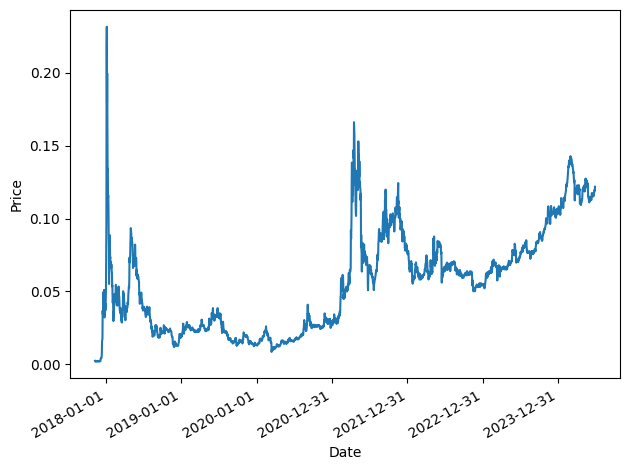

In [36]:
fig, ax = plt.subplots()

ax.plot(df["snapped_at"], df["price"])
ax.set_xlabel("Date")
ax.set_ylabel("Price")
# ax.axvspan(2056, 2421, color='#808080', alpha=0.2)

plt.xticks(np.arange(53, 2421,365))

fig.autofmt_xdate()
plt.tight_layout()

Is this Random Walk?


In [37]:
ADF_result = adfuller(df['price'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.5560854729933182
p-value: 0.10241735339644731


p-value is not less than 0.05 so cannot reject null hypothesis.


so we get difference

In [38]:
diff_price = np.diff(df['price'], n=1)

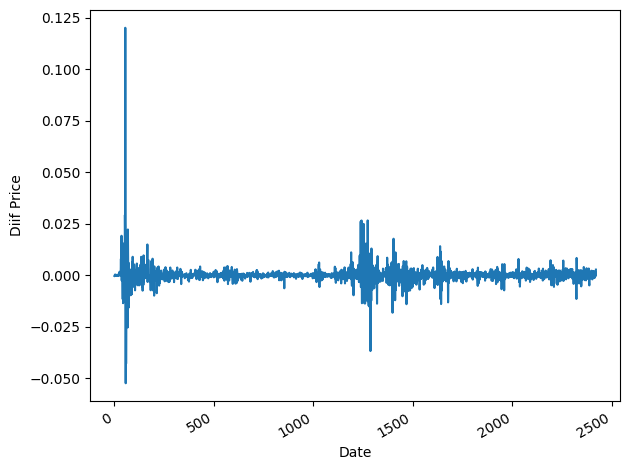

In [59]:
fig, ax = plt.subplots()

ax.plot(diff_price)
ax.set_xlabel("Date")
ax.set_ylabel("Diif Price")
# ax.axvspan(2056, 2421, color='#808080', alpha=0.2)

# plt.xticks(np.arange(53, 2421,365))

fig.autofmt_xdate()
plt.tight_layout()

In [39]:
diff_ADF_result = adfuller(diff_price)

print(f'ADF Statistic: {diff_ADF_result[0]}')
print(f'p-value: {diff_ADF_result[1]}')

ADF Statistic: -10.765182838268961
p-value: 2.4629867112565233e-19


p-value is less than 0.05 so diff_price is stationary.

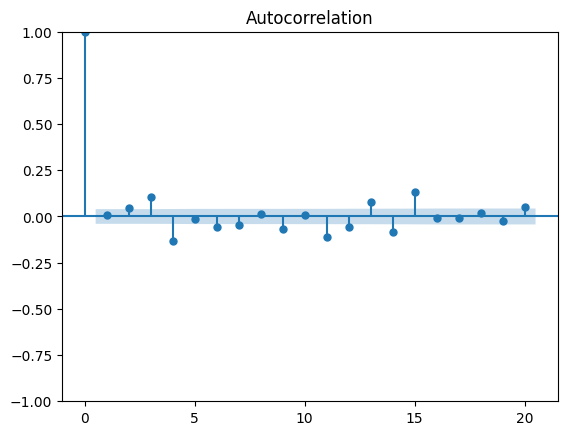

In [40]:
plot_acf(diff_price, lags=20);

Time series is very near to Random Walk. But not 100%

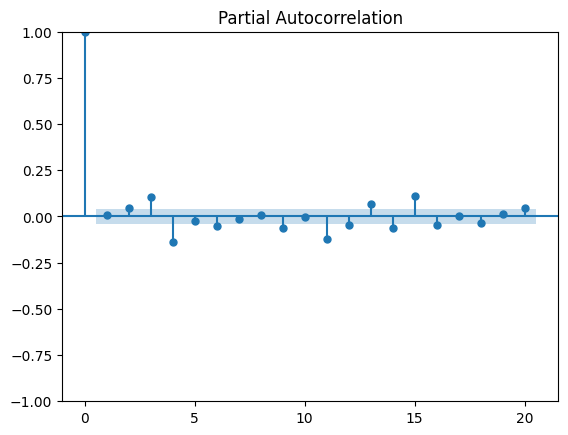

In [43]:
plot_pacf(diff_price, lags=20);

Not a AR models

In [46]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [48]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [49]:
result_df = optimize_ARMA(diff_price, order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 2)",-19513.573095
1,"(1, 3)",-19510.794359
2,"(2, 3)",-19510.277444
3,"(3, 3)",-19507.626511
4,"(0, 3)",-19498.629014
5,"(3, 0)",-19492.270761
6,"(3, 1)",-19490.139424
7,"(0, 2)",-19468.831281
8,"(2, 0)",-19468.064657
9,"(0, 0)",-19466.540198


Performing residuals analysis

Q-Q plot

In [72]:
model = SARIMAX(diff_price, order=(3, 0, 2), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

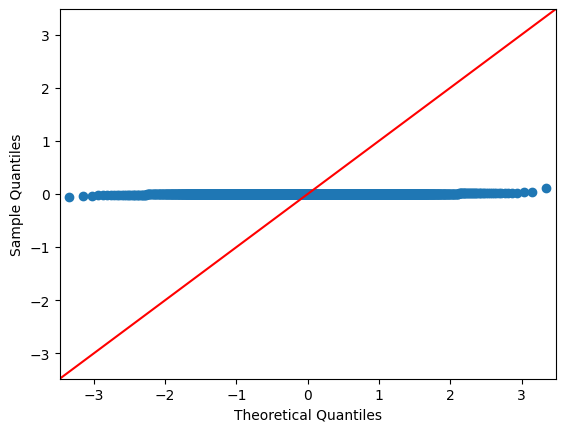

In [73]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='45');

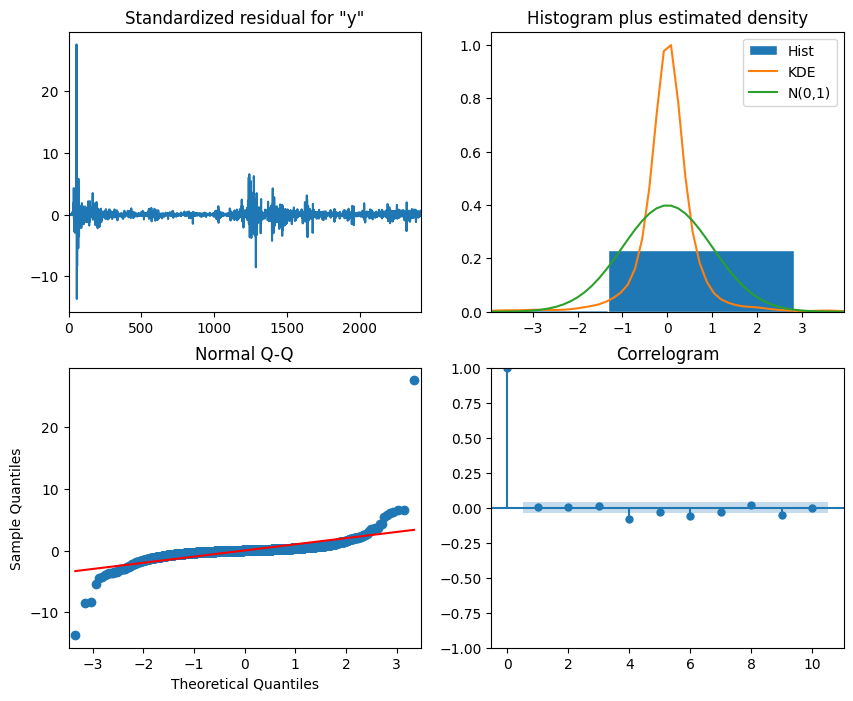

In [74]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [75]:
from statsmodels.stats.diagnostic import acorr_ljungbox

pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

      lb_stat  lb_pvalue
1    0.008718   0.925611
2    0.039633   0.980378
3    0.246812   0.969700
4   15.243987   0.004221
5   17.466842   0.003694
6   25.513092   0.000274
7   27.312911   0.000293
8   28.325812   0.000416
9   34.372178   0.000077
10  34.376070   0.000159


Forcasting

In [80]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [77]:
df_diff = pd.DataFrame({'diff_price': diff_price})

train = df_diff[:-365]
test = df_diff[-365:]

print(train.shape)
print(test.shape)

(2056, 1)
(365, 1)


In [86]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

,diff_price,pred_mean,pred_last_value,pred_ARMA
2056,0.000540,0.000035,0.000628,-0.000096
2057,-0.000587,0.000035,0.000540,0.000186
2058,0.000729,0.000035,-0.000587,0.000041
2059,0.001666,0.000035,0.000729,-0.000005
2060,0.001071,0.000036,0.001666,-0.000014


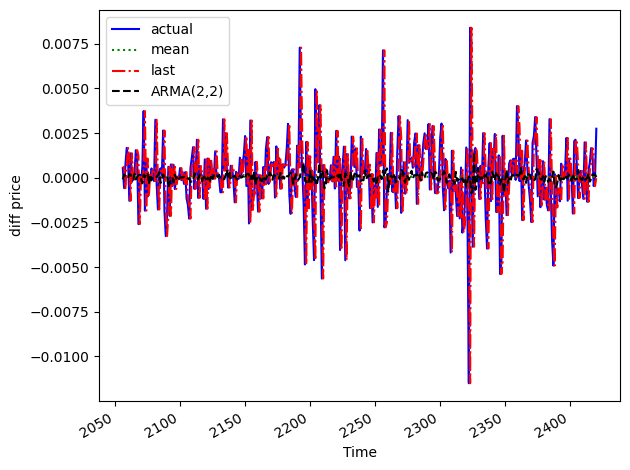

In [93]:
fig, ax = plt.subplots()

# ax.plot(df_diff['diff_price'])
ax.plot(test['diff_price'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('diff price')

# ax.axvspan(2000, 2500, color='#808080', alpha=0.2)

# ax.set_xlim(2000, 2500)

# plt.xticks(
#     [9802, 9850, 9898, 9946, 9994],
#     ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()


In [97]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_mean = mean_squared_error(test['diff_price'], test['pred_mean'])
mse_last = mean_squared_error(test['diff_price'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['diff_price'], test['pred_ARMA'])

print(mse_mean*10**6, mse_last*10**6, mse_ARMA*10**6)

3.5355210018876297 7.261473820070283 3.604189862774849


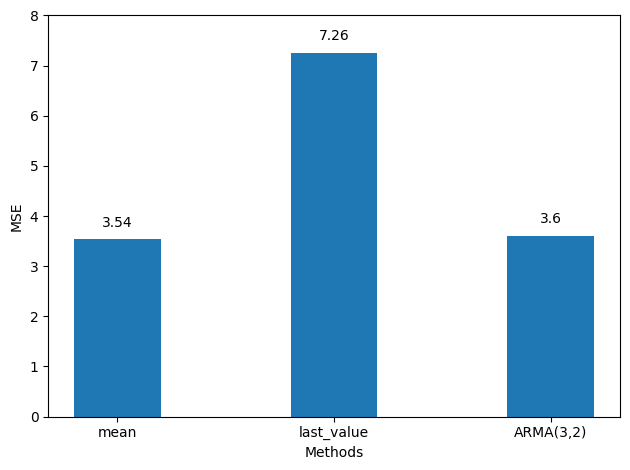

In [100]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'ARMA(3,2)']
y = [mse_mean*10**6, mse_last*10**6, mse_ARMA*10**6] 

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 8)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

In [110]:
df['pred_price'] = pd.Series()
df['pred_price'][-365:] = df['price'].iloc[-365] + test['pred_ARMA'].cumsum()

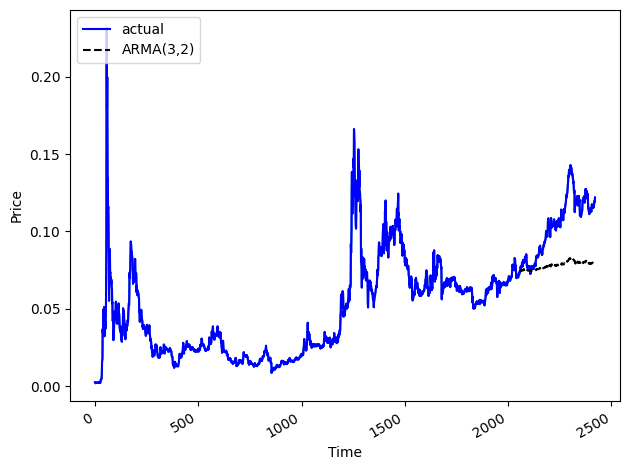

In [107]:
fig, ax = plt.subplots()

ax.plot(df['price'])
ax.plot(df['price'], 'b-', label='actual')
ax.plot(df['pred_price'], 'k--', label='ARMA(3,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Price')

# ax.axvspan(9831, 10000, color='#808080', alpha=0.2)

# ax.set_xlim(9800, 9999)

# plt.xticks(
#     [9802, 9850, 9898, 9946, 9994],
#     ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

In [108]:
mae_ARMA_undiff = mean_absolute_error(df['price'][-365:], df['pred_price'][-365:])

print(mae_ARMA_undiff)

0.02584541533883003
